In [1]:
"""Run a zero-inflated GP on opioid data"""
import os
import sys
from glob import glob

import numpy as np
import pandas as pd
idx = pd.IndexSlice
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import copy

import geopandas as gpd

from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

import gpflow
import tensorflow as tf
import sys
code_dir = '/cluster/home/kheuto01/code/zero-inflated-gp/'
sys.path.append(code_dir)
from math import radians, cos, sin, asin, sqrt
from onoffgpf import OnOffSVGP, OnOffLikelihood

import pickle

from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points
    on the earth (specified in decimal degrees)
    https://stackoverflow.com/a/4913653/1748679
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r


def top_X(y_true, y_pred, X=10):
    top_X_predicted = y_pred.sort_values(ascending=False)[:X]
    top_X_true = y_true.sort_values(ascending=False)[:X]

    undisputed_top_predicted = top_X_predicted[top_X_predicted > top_X_predicted.min()]
    num_tied_spots = X - len(undisputed_top_predicted)
    undisputed_top_true = top_X_true[top_X_true > top_X_true.min()]
    num_true_ties = X - len(undisputed_top_true)

    tied_top_predicted = top_X_predicted[top_X_predicted == top_X_predicted.min()]
    tied_top_true = top_X_true[top_X_true == top_X_true.min()]

    error_in_top_true_ties = np.abs(tied_top_true - y_pred[tied_top_true.index]).sort_values(ascending=True)
    error_in_top_pred_ties = np.abs(y_true[tied_top_predicted.index] - tied_top_predicted).sort_values(ascending=True)
    top_true_tied_geoids = error_in_top_true_ties[:num_true_ties].index
    top_pred_tied_geoids = error_in_top_pred_ties[:num_tied_spots].index

    best_possible_top_true_geoids = pd.Index.union(undisputed_top_true.index, top_true_tied_geoids)
    best_possible_top_pred_geoids = pd.Index.union(undisputed_top_predicted.index, top_pred_tied_geoids)

    # True values of GEOIDS with highest actual deaths. If ties, finds tied locations that match preds best
    best_possible_true = y_true[best_possible_top_true_geoids]
    best_possible_pred = y_true[best_possible_top_pred_geoids]

    assert (len(best_possible_true) == X)
    assert (len(best_possible_pred) == X)

    best_possible_absolute = np.abs(best_possible_true.sum() - best_possible_pred.sum())
    best_possible_ratio = np.abs(best_possible_pred).sum() / np.abs(best_possible_true).sum()

    bootstrapped_tied_indices = np.random.choice(tied_top_predicted.index, (1000, num_tied_spots))
    bootstrapped_all_indices = [pd.Index.union(undisputed_top_predicted.index,
                                               bootstrap_index) for bootstrap_index in bootstrapped_tied_indices]

    bootstrapped_absolute = np.mean([np.abs(top_X_true.sum() - y_true[indices].sum())
                                     for indices in bootstrapped_all_indices])
    bootstrapped_ratio = np.mean([np.abs(y_true[indices]).sum() / np.abs(top_X_true).sum()
                                  for indices in bootstrapped_all_indices])

    return best_possible_absolute, best_possible_ratio, bootstrapped_absolute, bootstrapped_ratio

def normcdf(x):
    return 0.5 * (1.0 + tf.math.erf(x / np.sqrt(2.0))) * (1. - 2.e-3) + 1.e-3


def fixed_top_X(true_qtr_val, pred_qtr_val, X=10):
    top_X_predicted = pred_qtr_val.sort_values(ascending=False)[:X]
    top_X_true = true_qtr_val.sort_values(ascending=False)[:X]

    undisputed_top_predicted = top_X_predicted[top_X_predicted > top_X_predicted.min()]
    num_tied_spots = X - len(undisputed_top_predicted)
    undisputed_top_true = top_X_true[top_X_true > top_X_true.min()]
    num_true_ties = X - len(undisputed_top_true)

    tied_top_predicted = pred_qtr_val[pred_qtr_val == top_X_predicted.min()]
    tied_top_true = true_qtr_val[true_qtr_val == top_X_true.min()]

    error_in_top_true_ties = np.abs(tied_top_true - pred_qtr_val[tied_top_true.index]).sort_values(ascending=True)
    error_in_top_pred_ties = np.abs(true_qtr_val[tied_top_predicted.index] - tied_top_predicted).sort_values(
        ascending=True)
    top_true_tied_geoids = error_in_top_true_ties[:num_true_ties].index
    top_pred_tied_geoids = error_in_top_pred_ties[:num_tied_spots].index

    best_possible_top_true_geoids = pd.Index.union(undisputed_top_true.index, top_true_tied_geoids)
    best_possible_top_pred_geoids = pd.Index.union(undisputed_top_predicted.index, top_pred_tied_geoids)

    # True values of GEOIDS with highest actual deaths. If ties, finds tied locations that match preds best
    best_possible_true = true_qtr_val[best_possible_top_true_geoids]
    best_possible_pred = true_qtr_val[best_possible_top_pred_geoids]

    assert (len(best_possible_true) == X)
    assert (len(best_possible_pred) == X)

    best_possible_absolute = np.abs(best_possible_true.sum() - best_possible_pred.sum())
    best_possible_ratio = np.abs(best_possible_pred).sum() / np.abs(best_possible_true).sum()

    bootstrapped_tied_indices = np.random.choice(tied_top_predicted.index, (1000, num_tied_spots))
    bootstrapped_all_indices = [pd.Index.union(undisputed_top_predicted.index,
                                               bootstrap_index) for bootstrap_index in bootstrapped_tied_indices]

    bootstrapped_absolute = np.mean([np.abs(top_X_true.sum() - true_qtr_val[indices].sum())
                                     for indices in bootstrapped_all_indices])
    bootstrapped_ratio = np.mean([np.abs(true_qtr_val[indices]).sum() / np.abs(top_X_true).sum()
                                  for indices in bootstrapped_all_indices])

    return best_possible_absolute, best_possible_ratio, bootstrapped_absolute, bootstrapped_ratio

2023-02-08 08:16:57.911614: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 08:16:58.034058: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-08 08:16:58.039470: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-08 08:16:58.039483: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
data_dir = '/cluster/tufts/hugheslab/datasets/NSF_OD/'
result_dir = os.path.join(data_dir, 'results_20220606_update')
mass_shapefile = os.path.join(data_dir,'shapefiles','MA_2021')

In [3]:
svi_file = os.path.join(result_dir, 'svi_month_town')
svi_gdf = gpd.read_file(svi_file)
# Call it "grid_squar" because geopandas only supports len 10 columns
svi_gdf = svi_gdf.rename(columns={'INTPTLAT20': 'lat', 'INTPTLON20': 'lon', 'GEOID20': 'grid_squar'})
# Make lat and lon floats
svi_gdf.loc[:, 'lat'] = svi_gdf.lat.astype(float)
svi_gdf.loc[:, 'lon'] = svi_gdf.lon.astype(float)
deaths_gdf = svi_gdf


In [4]:
    # Used when we just need the unique tracts and their locations
    just_grid = deaths_gdf.loc[
        (deaths_gdf['year'] == 2000) & (deaths_gdf['month'] == 1), ['grid_squar', 'geometry', 'lat', 'lon']]

    # Calculate each squares neighbors
    neighbors = {}
    for _, row in just_grid.iterrows():
        just_grid.loc[:, 'haversine'] = just_grid.apply(lambda x: haversine(row['lon'], row['lat'],
                                                                            x['lon'], x['lat']),
                                                        axis=1)
        matching_neighbors = just_grid[just_grid['haversine'] < 8]['grid_squar'].values
        neighbors[row['grid_squar']] = matching_neighbors

    tracts = deaths_gdf['grid_squar'].unique()
    min_year = deaths_gdf.year.min()
    max_year = deaths_gdf.year.max()
    deaths_gdf = deaths_gdf.set_index(['grid_squar', 'year', 'month']).sort_index()

    month_since_2000 = 0
    season_since_2000 = 0
    qtr_since_2000 = 0
    year_since_2000 = 0
    for year in range(min_year, max_year + 1):
        for month in range(1, 12 + 1):

            if month in [1, 2, 3, 4, 5, 6]:
                season = 'jan-jun'
            else:
                season = 'jul-dec'

            if month <= 3:
                qtr = 1
            elif month <= 6:
                qtr = 2
            elif month <= 9:
                qtr = 3
            else:
                qtr = 4

            deaths_gdf.loc[idx[:, year, month], 'month_since_2000'] = month_since_2000
            deaths_gdf.loc[idx[:, year, month], 'season'] = season
            deaths_gdf.loc[idx[:, year, month], 'season_since_2000'] = season_since_2000
            deaths_gdf.loc[idx[:, year, month], 'quarter'] = qtr
            deaths_gdf.loc[idx[:, year, month], 'qtr_since_2000'] = qtr_since_2000
            deaths_gdf.loc[idx[:, year, month], 'year_since_2000'] = year_since_2000

            month_since_2000 += 1

            if month in [6, 12]:
                season_since_2000 += 1

            if month in [3, 6, 9, 12]:
                qtr_since_2000 += 1

            if month == 12:
                year_since_2000 += 1

    deaths_gdf = deaths_gdf.reset_index()


In [5]:
timestep_col = 'quarter'

In [6]:
 
    deaths_gdf = deaths_gdf.set_index(['grid_squar', 'year', 'quarter']).sort_index()
    deaths_gdf.loc[idx[:, :, :], 'self_t-1'] = deaths_gdf.loc[idx[:, :, :], 'deaths'].shift(1, fill_value=0)
    unduped_gdf = deaths_gdf[~deaths_gdf.index.duplicated(keep='first')]
    summed_deaths = deaths_gdf.groupby(level=[0,1,2]).sum()[['deaths']]
    summed_deaths = summed_deaths.merge(unduped_gdf, how='left', left_index=True, right_index=True,suffixes=[None,'_garbage'])
    summed_deaths = summed_deaths.drop('deaths_garbage',axis=1)
    deaths_gdf = summed_deaths
    for tract in tracts:
        deaths_gdf.loc[idx[tract, :, :], 'neighbor_t-1'] = \
            deaths_gdf.loc[idx[neighbors[tract], :, :], 'self_t-1'].groupby(level=['year', 'quarter']).mean().shift(1,
                                                                                                                    fill_value=0).values

    timestep = 0

    for year in range(min_year, max_year + 1):
        for quarter in range(1, 5):
            deaths_gdf.loc[idx[:, year, quarter], 'timestep'] = timestep
            timestep += 1

    deaths_gdf_with_autoregressive = deaths_gdf.reset_index()

In [7]:
deaths_gdf_with_autoregressive

,grid_squar,year,quarter,deaths,month,STATEFP20,COUNTYFP20,COUSUBFP20,COUSUBNS20,NAMELSAD20,...,svi_pctile,geometry,month_since_2000,season,season_since_2000,qtr_since_2000,year_since_2000,self_t-1,neighbor_t-1,timestep
0,2500103690,2000,1.0,1.0,1,25,001,03690,00618248,Barnstable Town city,...,0.485828,"MULTIPOLYGON (((-70.38145 41.73987, -70.38121 ...",0.0,jan-jun,0.0,0.0,0.0,0.0,0.0,0.0
1,2500103690,2000,2.0,0.0,4,25,001,03690,00618248,Barnstable Town city,...,0.485828,"MULTIPOLYGON (((-70.38145 41.73987, -70.38121 ...",3.0,jan-jun,0.0,1.0,0.0,0.0,0.0,1.0
2,2500103690,2000,3.0,0.0,7,25,001,03690,00618248,Barnstable Town city,...,0.485828,"MULTIPOLYGON (((-70.38145 41.73987, -70.38121 ...",6.0,jul-dec,1.0,2.0,0.0,0.0,0.0,2.0
3,2500103690,2000,4.0,1.0,10,25,001,03690,00618248,Barnstable Town city,...,0.485828,"MULTIPOLYGON (((-70.38145 41.73987, -70.38121 ...",9.0,jul-dec,1.0,3.0,0.0,0.0,0.0,3.0
4,2500103690,2001,1.0,0.0,1,25,001,03690,00618248,Barnstable Town city,...,0.485828,"MULTIPOLYGON (((-70.38145 41.73987, -70.38121 ...",12.0,jan-jun,2.0,4.0,1.0,1.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30883,2502782000,2020,4.0,23.0,10,25,027,82000,00619493,Worcester city,...,0.731519,"POLYGON ((-71.76827 42.31126, -71.76749 42.310...",249.0,jul-dec,41.0,83.0,20.0,11.0,3.5,83.0
30884,2502782000,2021,1.0,23.0,1,25,027,82000,00619493,Worcester city,...,0.731519,"POLYGON ((-71.76827 42.31126, -71.76749 42.310...",252.0,jan-jun,42.0,84.0,21.0,13.0,5.5,84.0
30885,2502782000,2021,2.0,17.0,4,25,027,82000,00619493,Worcester city,...,0.731519,"POLYGON ((-71.76827 42.31126, -71.76749 42.310...",255.0,jan-jun,42.0,85.0,21.0,8.0,6.5,85.0
30886,2502782000,2021,3.0,30.0,7,25,027,82000,00619493,Worcester city,...,0.731519,"POLYGON ((-71.76827 42.31126, -71.76749 42.310...",258.0,jul-dec,43.0,86.0,21.0,6.0,4.0,86.0


In [8]:
features = ['grid_squar','year','quarter', 'lat', 'lon', timestep_col, 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc',
         'svi_pctile', 'neighbors_last_timestep', 'last_timestep']
features_no_idx = ['lat', 'lon', timestep_col, 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc',
 'svi_pctile', 'neighbors_last_timestep', 'last_timestep']

In [9]:
    train_x_through_2018 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year'] <= 2018][
        ['grid_squar', 'lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile',
         'neighbor_t-1', 'self_t-1']]
    train_y_through_2018 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year'] <= 2018][
        ['grid_squar', 'timestep', 'deaths']]
    train_x_through_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year'] <= 2019][
        ['grid_squar', 'lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile',
         'neighbor_t-1', 'self_t-1']]
    train_y_through_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year'] <= 2019][
        ['grid_squar', 'timestep', 'deaths']]

    x_just_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year'] == 2019][
        ['grid_squar', 'lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile',
         'neighbor_t-1', 'self_t-1']]
    y_just_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year'] == 2019][
        ['grid_squar', 'timestep', 'deaths']]
    x_just_2020 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year'] == 2020][
        ['grid_squar', 'lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile',
         'neighbor_t-1', 'self_t-1']]
    y_just_2020 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year'] == 2020][
        ['grid_squar', 'timestep', 'deaths']]

    x_just_2019q1 = deaths_gdf_with_autoregressive[
        (deaths_gdf_with_autoregressive['year'] == 2019) & (deaths_gdf_with_autoregressive['quarter'] == 1)][
        ['grid_squar', 'lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile',
         'neighbor_t-1', 'self_t-1']]
    y_just_2019q1 = deaths_gdf_with_autoregressive[
        (deaths_gdf_with_autoregressive['year'] == 2019) & (deaths_gdf_with_autoregressive['quarter'] == 1)][
        ['grid_squar', 'timestep', 'deaths']]

    spatial_kernel = gpflow.kernels.RBF(2, active_dims=[0, 1])
    temporal_kernel = gpflow.kernels.RBF(1, active_dims=[2])

2023-02-08 08:17:33.303539: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-08 08:17:33.303583: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: p1cmp078.pax.tufts.edu
2023-02-08 08:17:33.303594: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: p1cmp078.pax.tufts.edu
2023-02-08 08:17:33.303742: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.47.3
2023-02-08 08:17:33.303774: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.47.3
2023-02-08 08:17:33.303779: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.47.3
2023-02-08 08:17:33.304278: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the fo

In [10]:
        demo_kernel = gpflow.kernels.RBF(5, active_dims=[3, 4, 5, 6, 7])
        gaussian_kernel = spatial_kernel + temporal_kernel + demo_kernel
        autoregressive_kernel = gpflow.kernels.RBF(2, active_dims=[8, 9])
        gaussian_kernel = gaussian_kernel + autoregressive_kernel

In [11]:
inducing_points=200

In [12]:
def run_adam(model, iterations, out_dir, death_df, learning_rate=0.005):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    stat_logs = pd.DataFrame()
    stat_path = os.path.join(out_dir, 'stats.csv')
    model_path = os.path.join(out_dir, 'model.mod')
    training_loss = model.training_loss_closure(compile=True)
    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)#gpflow.optimizers.Adam(learning_rate=0.01)

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)

            maes = []
            xtop = []
            for quarter in range(1, 4 + 1):
                test_x = death_df[(death_df['year'] == 2019) & (
                            death_df['quarter'] == quarter)][
                    ['grid_squar', 'lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc',
                     'svi_pctile', 'neighbor_t-1', 'self_t-1']]
                test_y = death_df[(death_df['year'] == 2019) & (
                            death_df['quarter'] == quarter)][['grid_squar', 'timestep', 'deaths']]
                _, _, _, fmean, fvar, gmean, gvar, _, _ = model.build_predict(test_x.loc[:,
                                                                          ['lat', 'lon', 'timestep', 'theme_1_pc',
                                                                           'theme_2_pc', 'theme_3_pc', 'theme_4_pc',
                                                                           'svi_pctile', 'neighbor_t-1',
                                                                           'self_t-1']].values)
                sg_2019 = tf.math.softplus(fmean * normcdf(gmean) + 2).numpy()
                pred_2019_df = pd.Series(sg_2019.squeeze(), index=test_y.grid_squar)

                maes.append(mean_absolute_error(test_y.deaths, pred_2019_df))
                xtop.append(fixed_top_X(test_y.set_index('grid_squar')['deaths'], pred_2019_df, 100))

            stat_logs = stat_logs.append({'iter': step,'elbo':elbo, 'mae': np.mean(maes), 'bpr_100': np.mean([thing[3] for thing in xtop])},
                                         ignore_index=True)

            stat_logs.to_csv(stat_path)
            model.savemodel(model_path)


    return logf

In [13]:
    f_kernel = copy.deepcopy(gaussian_kernel)
    g_kernel = copy.deepcopy(gaussian_kernel)
    likelihood = OnOffLikelihood()
    random = np.random.default_rng(seed=360)

    M = inducing_points
    N = len(train_x_through_2018)
    Z = random.choice(train_x_through_2018[
                          ['lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc',
                           'svi_pctile', 'neighbor_t-1', 'self_t-1']].values, size=M, replace=False)

    Zf = copy.deepcopy(Z)
    Zg = copy.deepcopy(Z)



    m = OnOffSVGP(train_x_through_2018.loc[:, ['lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc',
                                                    'theme_3_pc', 'theme_4_pc', 'svi_pctile',
                                                    'neighbor_t-1', 'self_t-1']].values,
                       train_y_through_2018.loc[:, 'deaths'].values.reshape(-1, 1)
                  , kernf=f_kernel,
                  kerng=g_kernel
                  , likelihood=OnOffLikelihood()
                  , Zf=Zf,
                  Zg=Zg
                  )



In [ ]:
 logf = run_adam(m, 2000,'/cluster/home/kheuto01/try_thing_town/', deaths_gdf_with_autoregressive, learning_rate=0.01)

/tmp/ipykernel_288921/665276572.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stat_logs = stat_logs.append({'iter': step,'elbo':elbo, 'mae': np.mean(maes), 'bpr_100': np.mean([thing[3] for thing in xtop])},
/tmp/ipykernel_288921/665276572.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stat_logs = stat_logs.append({'iter': step,'elbo':elbo, 'mae': np.mean(maes), 'bpr_100': np.mean([thing[3] for thing in xtop])},
/tmp/ipykernel_288921/665276572.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stat_logs = stat_logs.append({'iter': step,'elbo':elbo, 'mae': np.mean(maes), 'bpr_100': np.mean([thing[3] for thing in xtop])},
/tmp/ipykernel_288921/665276572.py:46: FutureWarning: The frame.append method is deprecated

/tmp/ipykernel_288921/665276572.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stat_logs = stat_logs.append({'iter': step,'elbo':elbo, 'mae': np.mean(maes), 'bpr_100': np.mean([thing[3] for thing in xtop])},
/tmp/ipykernel_288921/665276572.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stat_logs = stat_logs.append({'iter': step,'elbo':elbo, 'mae': np.mean(maes), 'bpr_100': np.mean([thing[3] for thing in xtop])},
/tmp/ipykernel_288921/665276572.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stat_logs = stat_logs.append({'iter': step,'elbo':elbo, 'mae': np.mean(maes), 'bpr_100': np.mean([thing[3] for thing in xtop])},
/tmp/ipykernel_288921/665276572.py:46: FutureWarning: The frame.append method is deprecated

/tmp/ipykernel_288921/665276572.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stat_logs = stat_logs.append({'iter': step,'elbo':elbo, 'mae': np.mean(maes), 'bpr_100': np.mean([thing[3] for thing in xtop])},
/tmp/ipykernel_288921/665276572.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stat_logs = stat_logs.append({'iter': step,'elbo':elbo, 'mae': np.mean(maes), 'bpr_100': np.mean([thing[3] for thing in xtop])},
/tmp/ipykernel_288921/665276572.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stat_logs = stat_logs.append({'iter': step,'elbo':elbo, 'mae': np.mean(maes), 'bpr_100': np.mean([thing[3] for thing in xtop])},
/tmp/ipykernel_288921/665276572.py:46: FutureWarning: The frame.append method is deprecated

/tmp/ipykernel_288921/665276572.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stat_logs = stat_logs.append({'iter': step,'elbo':elbo, 'mae': np.mean(maes), 'bpr_100': np.mean([thing[3] for thing in xtop])},
/tmp/ipykernel_288921/665276572.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stat_logs = stat_logs.append({'iter': step,'elbo':elbo, 'mae': np.mean(maes), 'bpr_100': np.mean([thing[3] for thing in xtop])},
/tmp/ipykernel_288921/665276572.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stat_logs = stat_logs.append({'iter': step,'elbo':elbo, 'mae': np.mean(maes), 'bpr_100': np.mean([thing[3] for thing in xtop])},
/tmp/ipykernel_288921/665276572.py:46: FutureWarning: The frame.append method is deprecated

/tmp/ipykernel_288921/665276572.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stat_logs = stat_logs.append({'iter': step,'elbo':elbo, 'mae': np.mean(maes), 'bpr_100': np.mean([thing[3] for thing in xtop])},
/tmp/ipykernel_288921/665276572.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stat_logs = stat_logs.append({'iter': step,'elbo':elbo, 'mae': np.mean(maes), 'bpr_100': np.mean([thing[3] for thing in xtop])},
/tmp/ipykernel_288921/665276572.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stat_logs = stat_logs.append({'iter': step,'elbo':elbo, 'mae': np.mean(maes), 'bpr_100': np.mean([thing[3] for thing in xtop])},
/tmp/ipykernel_288921/665276572.py:46: FutureWarning: The frame.append method is deprecated

/tmp/ipykernel_288921/665276572.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stat_logs = stat_logs.append({'iter': step,'elbo':elbo, 'mae': np.mean(maes), 'bpr_100': np.mean([thing[3] for thing in xtop])},
/tmp/ipykernel_288921/665276572.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stat_logs = stat_logs.append({'iter': step,'elbo':elbo, 'mae': np.mean(maes), 'bpr_100': np.mean([thing[3] for thing in xtop])},
/tmp/ipykernel_288921/665276572.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stat_logs = stat_logs.append({'iter': step,'elbo':elbo, 'mae': np.mean(maes), 'bpr_100': np.mean([thing[3] for thing in xtop])},
/tmp/ipykernel_288921/665276572.py:46: FutureWarning: The frame.append method is deprecated

In [78]:
!mkdir /cluster/home/kheuto01/try_thing_town

In [12]:
for tract in tracts:
     deaths_gdf.loc[idx[tract,:,:],'neighbor_t-1']= \
        deaths_gdf.loc[idx[neighbors[tract],:,:],'self_t-1'].groupby(level=['year', 'quarter']).mean().shift(1, fill_value=0).values

In [63]:
deaths_gdf.loc[idx[tract,2011,:],:]

deaths  delta_deaths  last_timestep  \
grid_squar year quarter qtr_since_2000                                        
2502782000 2011 1.0     44.0               3.0          -2.0            5.0   
                2.0     45.0               4.0           1.0            3.0   
                3.0     46.0               8.0           4.0            4.0   
                4.0     47.0               6.0          -2.0            8.0   

                                        last_year  neighbors_last_timestep  \
grid_squar year quarter qtr_since_2000                                       
2502782000 2011 1.0     44.0                  3.0                      2.0   
                2.0     45.0                  5.0                      2.5   
                3.0     46.0                  3.0                      1.5   
                4.0     47.0                  4.0                      2.0   

                                        neighbors_last_year  theme_3_pc  \
grid_squar year quarter qtr_since_2000                                    
2502782000 2011 1.0     44.0                            2.5    0.726587   
                2.0     45.0                            3.5    0.726587   
                3.0     46.0                            6.5    0.726587   
                4.0     47.0                            2.5    0.726587   

                                              lon  theme_2_pc        lat  \
grid_squar year quarter qtr_since_2000                                     
2502782000 2011 1.0     44.0           -71.807783    0.567609  42.269478   
                2.0     45.0           -71.807783    0.567609  42.269478   
                3.0     46.0           -71.807783    0.567609  42.269478   
                4.0     47.0           -71.807783    0.567609  42.269478   

                                        svi_pctile  theme_1_pc  theme_4_pc  
grid_squar year quarter qtr_since_2000                                      
2502782000 2011 1.0     44.0              0.675293    0.684139     0.56787  
                2.0     45.0              0.675293    0.684139     0.56787  
                3.0     46.0              0.675293    0.684139     0.56787  
                4.0     47.0              0.675293    0.684139     0.56787

In [14]:
timestep = 0

for year in range(min_year, max_year+1):
    for quarter in range(1, 5):
        deaths_gdf.loc[idx[:,year, quarter], 'timestep'] = timestep
        timestep+=1

In [15]:
deaths_gdf.loc[idx[:,2012,:],:]

STATEFP COUNTYFP TRACTCE     NAME  \
grid_squar  year quarter                                     
25001010100 2012 1            25      001   10100      101   
                 2            25      001   10100      101   
                 3            25      001   10100      101   
                 4            25      001   10100      101   
25001010206 2012 1            25      001   10206   102.06   
...                          ...      ...     ...      ...   
25027761401 2012 4            25      027  761401  7614.01   
25027761402 2012 1            25      027  761402  7614.02   
                 2            25      027  761402  7614.02   
                 3            25      027  761402  7614.02   
                 4            25      027  761402  7614.02   

                                      NAMELSAD  MTFCC FUNCSTAT     ALAND  \
grid_squar  year quarter                                                   
25001010100 2012 1            Census Tract 101  G5020        S  25046216   
                 2            Census Tract 101  G5020        S  25046216   
                 3            Census Tract 101  G5020        S  25046216   
                 4            Census Tract 101  G5020        S  25046216   
25001010206 2012 1         Census Tract 102.06  G5020        S  51240906   
...                                        ...    ...      ...       ...   
25027761401 2012 4        Census Tract 7614.01  G5020        S  42913109   
25027761402 2012 1        Census Tract 7614.02  G5020        S  25568170   
                 2        Census Tract 7614.02  G5020        S  25568170   
                 3        Census Tract 7614.02  G5020        S  25568170   
                 4        Census Tract 7614.02  G5020        S  25568170   

                            AWATER        lat  ...  theme_4_pc  svi_pctile  \
grid_squar  year quarter                       ...                           
25001010100 2012 1        12765872  42.059829  ...       0.720      0.4528   
                 2        12765872  42.059829  ...       0.720      0.4528   
                 3        12765872  42.059829  ...       0.720      0.4528   
                 4        12765872  42.059829  ...       0.720      0.4528   
25001010206 2012 1        18828934  41.922636  ...       0.225      0.0602   
...                            ...        ...  ...         ...         ...   
25027761401 2012 4         1640138  42.489753  ...       0.304      0.2291   
25027761402 2012 1          209089  42.531342  ...       0.304      0.2291   
                 2          209089  42.531342  ...       0.304      0.2291   
                 3          209089  42.531342  ...       0.304      0.2291   
                 4          209089  42.531342  ...       0.304      0.2291   

                                 FIPS  ROUNDED_TR  ROUNDED__1  TRACTCE_y  \
grid_squar  year quarter                                                   
25001010100 2012 1        25001010100        None        None       None   
                 2        25001010100        None        None       None   
                 3        25001010100        None        None       None   
                 4        25001010100        None        None       None   
25001010206 2012 1        25001010206        None        None       None   
...                               ...         ...         ...        ...   
25027761401 2012 4               None      761400      761400       None   
25027761402 2012 1               None      761400      761400       None   
                 2               None      761400      761400       None   
                 3               None      761400      761400       None   
                 4               None      761400      761400       None   

                                                                   geometry  \
grid_squar  year quarter                                                      
25001010100 2012 1        POLYGON ((-70.25001 42.06410, -70.24959 4

In [16]:
deaths_gdf_with_autoregressive = deaths_gdf.reset_index()

In [17]:
deaths_gdf_with_autoregressive

,grid_squar,year,quarter,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,...,theme_4_pc,svi_pctile,FIPS,ROUNDED_TR,ROUNDED__1,TRACTCE_y,geometry,self_t-1,neighbor_t-1,timestep
0,25001010100,2000,1,25,001,10100,101,Census Tract 101,G5020,S,...,0.6872,0.6230,25001010100,None,None,None,"POLYGON ((-70.25001 42.06410, -70.24959 42.065...",0.0,0.000,0.0
1,25001010100,2000,2,25,001,10100,101,Census Tract 101,G5020,S,...,0.6872,0.6230,25001010100,None,None,None,"POLYGON ((-70.25001 42.06410, -70.24959 42.065...",0.0,0.000,1.0
2,25001010100,2000,3,25,001,10100,101,Census Tract 101,G5020,S,...,0.6872,0.6230,25001010100,None,None,None,"POLYGON ((-70.25001 42.06410, -70.24959 42.065...",0.0,0.000,2.0
3,25001010100,2000,4,25,001,10100,101,Census Tract 101,G5020,S,...,0.6872,0.6230,25001010100,None,None,None,"POLYGON ((-70.25001 42.06410, -70.24959 42.065...",0.0,0.000,3.0
4,25001010100,2001,1,25,001,10100,101,Census Tract 101,G5020,S,...,0.6872,0.6230,25001010100,None,None,None,"POLYGON ((-70.25001 42.06410, -70.24959 42.065...",0.0,0.000,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142555,25027761402,2020,4,25,027,761402,7614.02,Census Tract 7614.02,G5020,S,...,0.1598,0.2237,None,761400,761400,None,"POLYGON ((-71.63921 42.53096, -71.63906 42.531...",0.0,0.250,83.0
142556,25027761402,2021,1,25,027,761402,7614.02,Census Tract 7614.02,G5020,S,...,0.1598,0.2237,None,761400,761400,None,"POLYGON ((-71.63921 42.53096, -71.63906 42.531...",0.0,0.250,84.0
142557,25027761402,2021,2,25,027,761402,7614.02,Census Tract 7614.02,G5020,S,...,0.1598,0.2237,None,761400,761400,None,"POLYGON ((-71.63921 42.53096, -71.63906 42.531...",1.0,0.000,85.0
142558,25027761402,2021,3,25,027,761402,7614.02,Census Tract 7614.02,G5020,S,...,0.1598,0.2237,None,761400,761400,None,"POLYGON ((-71.63921 42.53096, -71.63906 42.531...",0.0,0.375,86.0


In [22]:
train_x_through_2018 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2018][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
train_y_through_2018 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2018][['grid_squar',  'timestep', 'deaths']]
train_x_through_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2019][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
train_y_through_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2019][['grid_squar', 'timestep', 'deaths']]

x_just_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2019][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile','neighbor_t-1', 'self_t-1']]
y_just_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2019][['grid_squar','timestep', 'deaths']]
x_just_2020 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2020][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
y_just_2020 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2020][['grid_squar', 'timestep', 'deaths']]

x_just_2019q1 = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019) & (deaths_gdf_with_autoregressive['quarter']==1)][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile','neighbor_t-1', 'self_t-1']]
y_just_2019q1 = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019) & (deaths_gdf_with_autoregressive['quarter']==1)][['grid_squar','timestep', 'deaths']]


In [18]:
spatial_kernel = gpflow.kernels.RBF(2, active_dims=[0,1])
temporal_kernel = gpflow.kernels.RBF(1, active_dims=[2])
demo_kernel =  gpflow.kernels.RBF(7,active_dims=[3,4,5,6,7,8,9])
gaussian_kernel = spatial_kernel + temporal_kernel + demo_kernel

f_kernel = copy.deepcopy(gaussian_kernel)
g_kernel = copy.deepcopy(gaussian_kernel)


In [19]:
likelihood = OnOffLikelihood()

In [20]:
random = np.random.default_rng(seed=1)

In [21]:
M = 200
N = len(train_x_through_2018)
Z = random.choice(train_x_through_2018[['lat','lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']].values, size=M, replace=False)

Zf = copy.deepcopy(Z)
Zg = copy.deepcopy(Z)

train_dataset = tf.data.Dataset.from_tensor_slices((train_x_through_2018.loc[:, ['lat','lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']], 
                                                   train_y_through_2018.loc[:,'deaths'].values.reshape(-1,1))).repeat().shuffle(N)


In [22]:
class LoggerCB(object):
    def __init__(self):
        self.logs = []
    def cb(self, result):
        print(result)
        self.logs.append(result['fun'])
logger_cb = LoggerCB()

In [23]:
m = OnOffSVGP(train_x_through_2018.loc[:, ['lat','lon','timestep','theme_1_pc', 'theme_2_pc',
                                           'theme_3_pc', 'theme_4_pc', 'svi_pctile',
                                           'neighbor_t-1', 'self_t-1']].values,
              train_y_through_2018.loc[:,'deaths'].values.reshape(-1,1)
              ,kernf=f_kernel,
              kerng=g_kernel
              ,likelihood = OnOffLikelihood()
              ,Zf = Zf,
              Zg = Zg
             )

# fix the model noise term
m.likelihood.variance = 0.01
m.likelihood.variance.fixed = False

In [50]:
train_x_through_2018.loc[:, ['lat','lon','timestep','theme_1_pc', 'theme_2_pc',
                                           'theme_3_pc', 'theme_4_pc', 'svi_pctile',
                                           'neighbor_t-1', 'self_t-1']].values

array([[ 42.0598291, -70.2004073,   0.       , ...,   0.623    ,
          0.       ,   0.       ],
       [ 42.0598291, -70.2004073,   1.       , ...,   0.623    ,
          0.       ,   0.       ],
       [ 42.0598291, -70.2004073,   2.       , ...,   0.623    ,
          0.       ,   0.       ],
       ...,
       [ 42.5313417, -71.5927511,  73.       , ...,   0.1229   ,
          0.25     ,   0.       ],
       [ 42.5313417, -71.5927511,  74.       , ...,   0.1229   ,
          0.       ,   0.       ],
       [ 42.5313417, -71.5927511,  75.       , ...,   0.1229   ,
          0.125    ,   1.       ]])

In [74]:
%%time
opt_result= m.optimize(maxiter = 200) #,method= tf.train.AdamOptimizer(learning_rate = 0.01)
print(m.compute_log_likelihood())
opt_result

-55346.13810928944
CPU times: user 56min 45s, sys: 22min 40s, total: 1h 19min 25s
Wall time: 40min 13s


      fun: 55346.13810928945
 hess_inv: <4813x4813 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.05560826,  0.03335286, -0.04420543, ..., -0.54635153,
       -0.21253859, -0.38487209])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 218
      nit: 200
     njev: 218
   status: 1
  success: False
        x: array([ 40.82279859, -70.89026979,  56.23345841, ...,  -0.89033864,
         0.27274592,   0.54196997])

In [75]:
m.mean_function(m.sorted_params)

TypeError: Failed to convert object of type <class 'list'> to Tensor. Contents: [<gpflow.param.Param object at 0x7fbde0435080>, <gpflow.param.Param object at 0x7fbde0435588>, <gpflow.kernels.Add object at 0x7fbde0432470>, <gpflow.kernels.Add object at 0x7fbde0434278>, <onoffgpf.OnOffLikelihood.OnOffLikelihood object at 0x7fbde0434630>, <gpflow.mean_functions.Zero object at 0x7fbde0432588>, <gpflow.param.Param object at 0x7fbde0435518>, <gpflow.param.Param object at 0x7fbde0435470>, <gpflow.param.Param object at 0x7fbde04354a8>, <gpflow.param.Param object at 0x7fbde0435400>]. Consider casting elements to a supported type.

In [32]:
logger_cb

In [30]:
sg_2019 = m.predict_onoffgp(x_just_2019q1.loc[:, ['lat','lon','timestep','theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']].values)
sg_2019 = sg_2019[0]

In [31]:
sg_2019.min()

-0.03863501663441614

In [32]:
sg_2019[-1]

array([0.16639467])

In [33]:
pred_2019_df = pd.Series(sg_2019.squeeze(), index=x_just_2019q1.grid_squar)


In [34]:
y_just_2019q1

,grid_squar,timestep,deaths
76,25001010100,76.0,0.0
164,25001010206,76.0,0.0
252,25001010208,76.0,0.0
340,25001010304,76.0,0.0
428,25001010306,76.0,0.0
...,...,...,...
142196,25027761100,76.0,0.0
142284,25027761200,76.0,0.0
142372,25027761300,76.0,1.0
142460,25027761401,76.0,0.0


In [35]:
sg_MAE_2019 = mean_absolute_error(y_just_2019q1.deaths, pred_2019_df)

sg_MLAE_2019 = mean_log_absolute_error(y_just_2019q1.deaths, pred_2019_df)

sg_top_10_2019 = top_X(y_just_2019q1.set_index('grid_squar')['deaths'], pred_2019_df, 10)
sg_top_50_2019 = top_X(y_just_2019q1.set_index('grid_squar')['deaths'], pred_2019_df, 50)
sg_top_100_2019 = top_X(y_just_2019q1.set_index('grid_squar')['deaths'], pred_2019_df, 100)

In [36]:
sg_MAE_2019

0.38190415392137683

In [37]:
sg_top_10_2019

(25.0, 0.21875, 25.0, 0.21875)

In [38]:
sg_top_100_2019

(102.0, 0.4, 102.0, 0.4000000000000001)

In [39]:
def mean_log_absolute_error(y_true, y_pred):
    
    min_val = abs(min(min(y_true), min(y_pred))) + 1

    return np.average(np.abs(np.log(y_pred.values+min_val) -
                             np.log(y_true.values+min_val)), axis=0)
def top_X(y_true, y_pred, X=10):
    
    top_X_predicted = y_pred.sort_values(ascending=False)[:X]
    top_X_true = y_true.sort_values(ascending=False)[:X]
    
    undisputed_top_predicted = top_X_predicted[top_X_predicted>top_X_predicted.min()]
    num_tied_spots = X - len(undisputed_top_predicted)
    undisputed_top_true = top_X_true[top_X_true > top_X_true.min()]
    num_true_ties = X - len(undisputed_top_true)
    
    tied_top_predicted = top_X_predicted[top_X_predicted==top_X_predicted.min()]
    tied_top_true = top_X_true[top_X_true==top_X_true.min()]
    
    error_in_top_true_ties = np.abs(tied_top_true-y_pred[tied_top_true.index]).sort_values(ascending=True)
    error_in_top_pred_ties = np.abs(y_true[tied_top_predicted.index]-tied_top_predicted).sort_values(ascending=True)
    top_true_tied_geoids = error_in_top_true_ties[:num_true_ties].index
    top_pred_tied_geoids = error_in_top_pred_ties[:num_tied_spots].index

    best_possible_top_true_geoids = pd.Index.union(undisputed_top_true.index, top_true_tied_geoids)
    best_possible_top_pred_geoids = pd.Index.union(undisputed_top_predicted.index, top_pred_tied_geoids)
    
    # True values of GEOIDS with highest actual deaths. If ties, finds tied locations that match preds best
    best_possible_true = y_true[best_possible_top_true_geoids]
    best_possible_pred = y_true[best_possible_top_pred_geoids]

    assert(len(best_possible_true)==X)
    assert(len(best_possible_pred)==X)
    
    best_possible_absolute = np.abs(best_possible_true.sum() - best_possible_pred.sum())
    best_possible_ratio = np.abs(best_possible_pred).sum()/np.abs(best_possible_true).sum()
    
    
    bootstrapped_tied_indices = np.random.choice(tied_top_predicted.index, (1000, num_tied_spots))
    bootstrapped_all_indices =  [pd.Index.union(undisputed_top_predicted.index,
                                                bootstrap_index) for bootstrap_index in bootstrapped_tied_indices]
    
    bootstrapped_absolute = np.mean([np.abs(top_X_true.sum() - y_true[indices].sum()) 
                                     for indices in bootstrapped_all_indices])
    bootstrapped_ratio = np.mean([np.abs(y_true[indices]).sum()/np.abs(top_X_true).sum()
                                  for indices in bootstrapped_all_indices])
    
    return best_possible_absolute, best_possible_ratio, bootstrapped_absolute, bootstrapped_ratio

In [40]:
print(sg_MAE_2019 )

print(sg_MLAE_2019 )

print(sg_top_10_2019 [0])
print(sg_top_50_2019[0])
print(sg_top_100_2019 [0])
print(sg_top_10_2019 [1])
print(sg_top_50_2019[1])
print(sg_top_100_2019 [1])


0.38190415392137683
0.2653638502108166
25.0
79.0
102.0
0.21875
0.29464285714285715
0.4


In [41]:
deaths_and_preds = y_just_2019.merge(pred_2019_df.rename('pred_deaths'),left_on='grid_squar', right_index=True)

baseline_2019_df =deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2018) &
                                                 (deaths_gdf_with_autoregressive['quarter']==1)][['grid_squar','deaths']]
    
baseline_2019_df = pd.Series(baseline_2019_df['deaths'].values, index=baseline_2019_df['grid_squar'])
deaths_and_baseline = y_just_2019.merge(baseline_2019_df.rename('pred_deaths'),left_on='grid_squar', right_index=True)

In [42]:
deaths_and_preds.loc[:,'residuals'] = deaths_and_preds.deaths-deaths_and_preds.pred_deaths
deaths_and_baseline.loc[:,'residuals'] = deaths_and_baseline.deaths-deaths_and_baseline.pred_deaths

In [43]:
residual_gdf = just_grid.merge(deaths_and_preds, on='grid_squar')
residual_baseline_gdf = just_grid.merge(deaths_and_baseline, on='grid_squar')

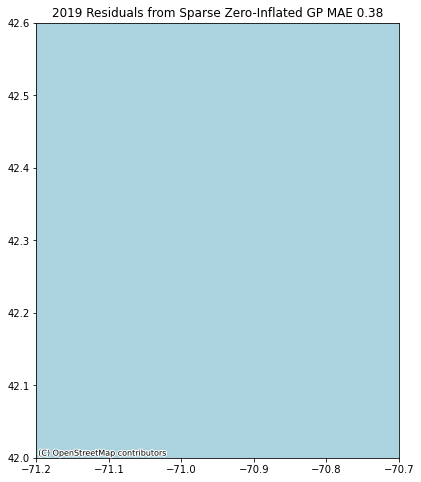

In [154]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
#residual_gdf.plot(column='residuals', cmap='RdBu_r',ax=ax, 
#                  legend=True, vmax=4, vmin=-4, alpha=0.05)
plt.title(f'2019 Residuals from Sparse Zero-Inflated GP MAE {sg_MAE_2019:.2f}')
plt.xlim([-71.2, -70.7])
plt.ylim([42, 42.6])
ctx.add_basemap(ax, zoom=5,source=ctx.providers.OpenStreetMap.Mapnik);

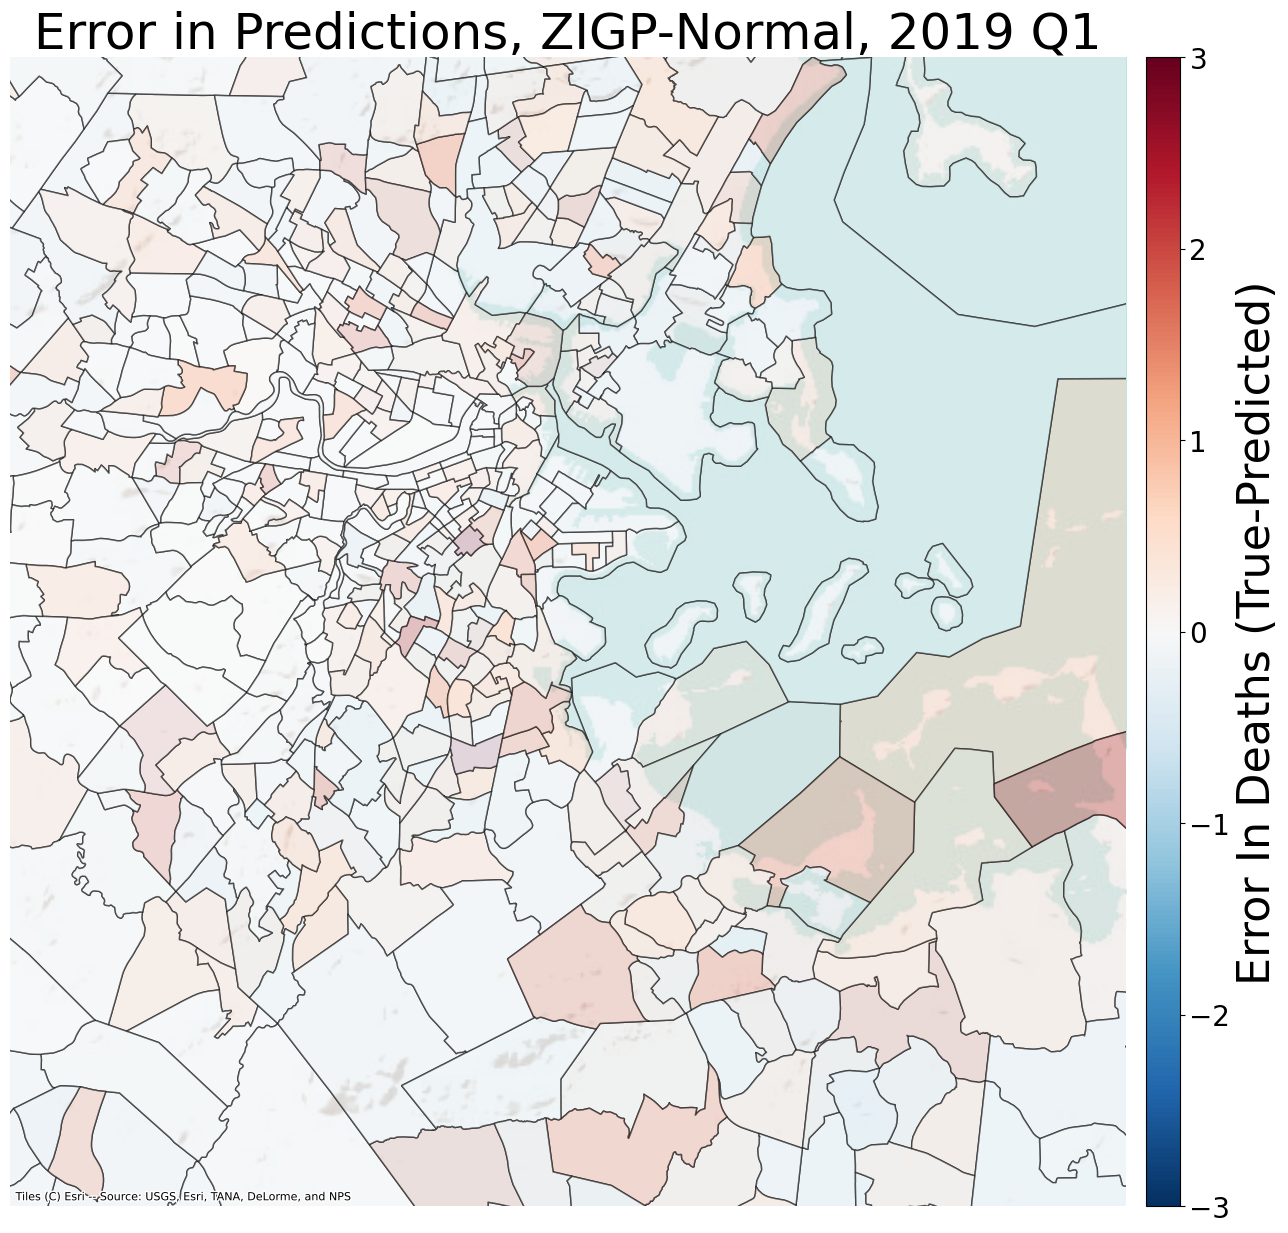

In [52]:
data='residuals'
cmap='RdBu_r'
zoom=11
dpi=100

#w,s,e,n = states.total_bounds

residual_gdf.crs = "EPSG:4326"

cropped_gdf = residual_gdf[(residual_gdf['lat']>42.2)&(residual_gdf['lat']<42.4)&
                           (residual_gdf['lon']>-71.2)&(residual_gdf['lon']<-70.93)]

f,ax = plt.subplots(1,1, figsize=(20,12), sharex=True, sharey=True, dpi=dpi)
f.tight_layout(pad=0.8)
ax.set_axis_off()
minx, miny, maxx, maxy = cropped_gdf.to_crs(epsg=3857).total_bounds
ax.set_xlim(minx, maxx-(maxx-minx)*0.4)
ax.set_ylim(miny, maxy)
plt.title('Error in Predictions, ZIGP-Normal, 2019 Q1',fontsize=36)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
ux = residual_gdf.to_crs(epsg=3857).plot(data, ax=ax, edgecolor='k', cmap=cmap,
                                         vmin=-cropped_gdf_baseline['residuals'].max(),
                                         vmax=cropped_gdf_baseline['residuals'].max(),
                                         alpha = 0.2, legend=True, cax=cax)
cax.tick_params(labelsize=20)
ctx.add_basemap(ux, zoom=zoom,reset_extent=True,source=ctx.providers.Esri.WorldTerrain);

plt.ylabel('Error In Deaths (True-Predicted)', fontsize=32)
# Use savefig to save your map
plt.savefig('map1zigp_N.png',bbox_inches='tight')
plt.show()

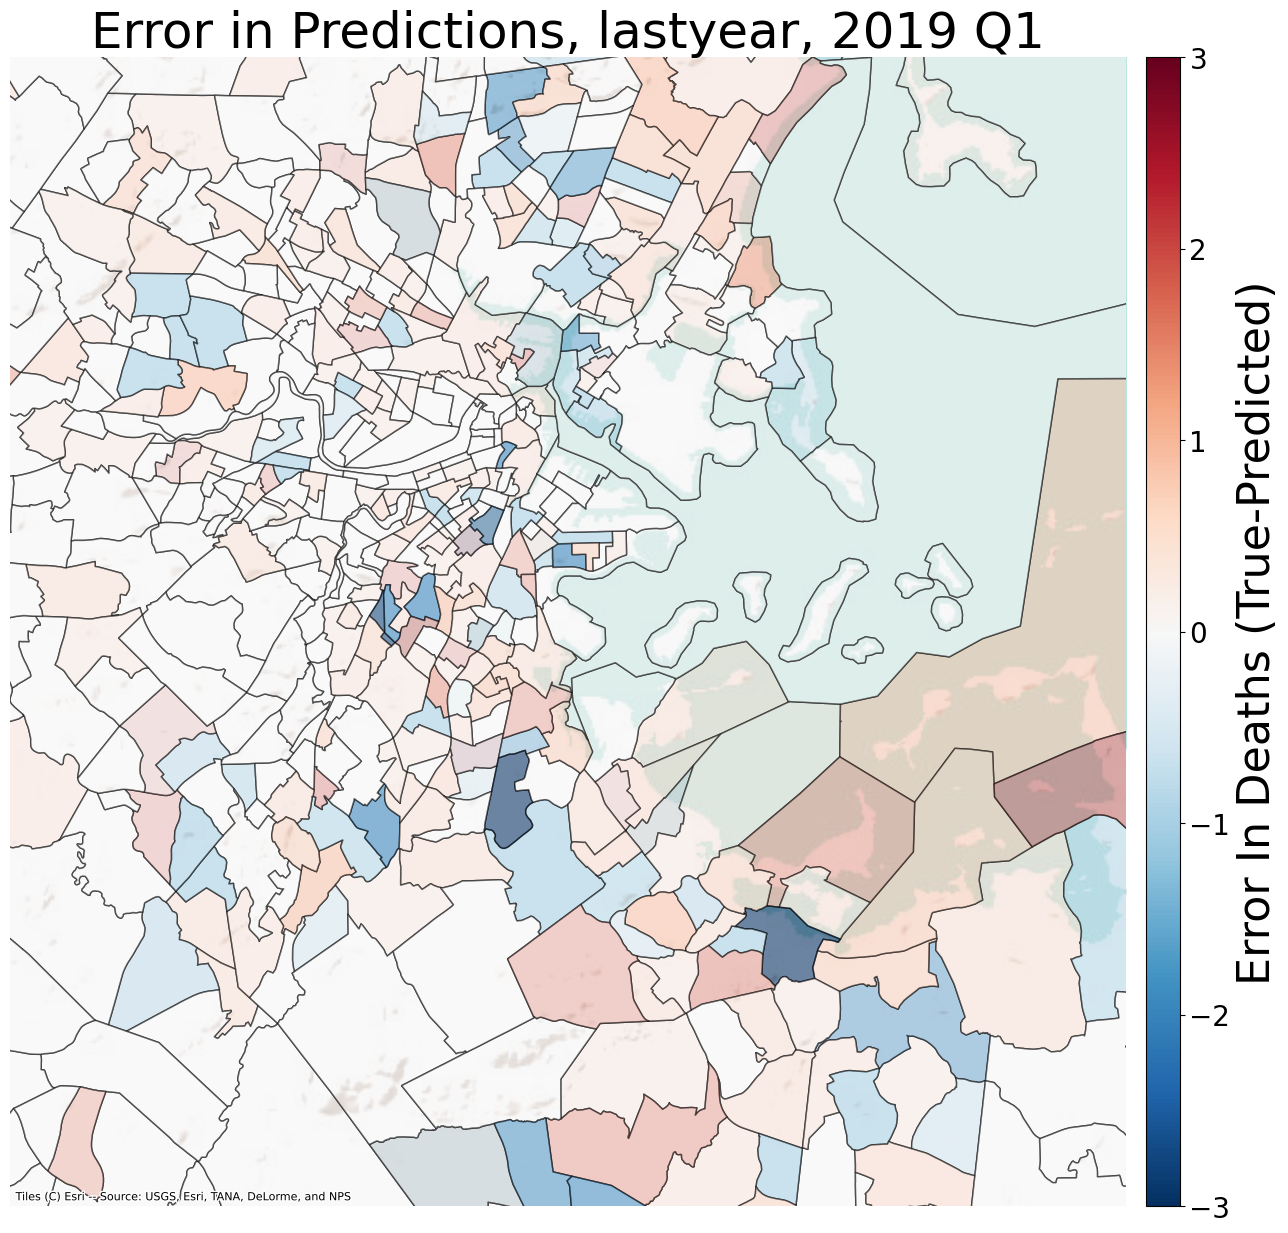

In [53]:
data='residuals'
cmap='RdBu_r'
zoom=11
dpi=100

#w,s,e,n = states.total_bounds

residual_baseline_gdf.crs = "EPSG:4326"

cropped_gdf_baseline = residual_baseline_gdf[(residual_baseline_gdf['lat']>42.2)&(residual_gdf['lat']<42.4)&
                           (residual_baseline_gdf['lon']>-71.2)&(residual_gdf['lon']<-70.93)]

f,ax = plt.subplots(1,1, figsize=(20,12), sharex=True, sharey=True, dpi=dpi)
f.tight_layout(pad=0.8)
ax.set_axis_off()
minx, miny, maxx, maxy = cropped_gdf_baseline.to_crs(epsg=3857).total_bounds
ax.set_xlim(minx, maxx-(maxx-minx)*0.4)
ax.set_ylim(miny, maxy)
plt.title('Error in Predictions, lastyear, 2019 Q1',fontsize=36)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
ux = residual_baseline_gdf.to_crs(epsg=3857).plot(data, ax=ax, edgecolor='k', cmap=cmap,
                                         vmin=-cropped_gdf_baseline['residuals'].max(),
                                         vmax=cropped_gdf_baseline['residuals'].max(),
                                         alpha = 0.2, legend=True, cax=cax)
ctx.add_basemap(ux, zoom=zoom,reset_extent=True,source=ctx.providers.Esri.WorldTerrain);

cax.tick_params(labelsize=20)

plt.ylabel('Error In Deaths (True-Predicted)', fontsize=32)
# Use savefig to save your map
plt.savefig('map1lastyear.png',bbox_inches='tight')
plt.show()

In [92]:
comparisons = pd.read_csv(os.path.join(result_dir,'comparisons.csv'))
comparisons

,name,lat,lon,center,neighbors
0,N. Cambridge,42.3934,-71.1309,607,[581 582 583 606 607 608 631 632 633]
1,Jamaica Plain,42.3132,-71.1141,605,[579 580 581 604 605 606 629 630 631]
2,Springfield,42.1015,-72.5898,206,[191 192 193 205 206 207 219 220 221]
3,Pittsfield,42.4501,-73.2454,43,[29 30 31 42 43 44 56 57 58]
4,Brockton,42.0834,-71.0184,651,[625 626 627 650 651 652 678 679 680]
5,Lawrence,42.7070,-71.1631,612,[586 587 588 611 612 613 636 637 638]
6,Nantucket,41.2835,-70.0995,918,[911 917 918 919 928 929 930]
7,Falmouth,41.5532,-70.6086,848,[827 828 829 847 848 849 863 864 865]


Text(0.5, 1.05, 'Data for comparison locations, 2001-2019')

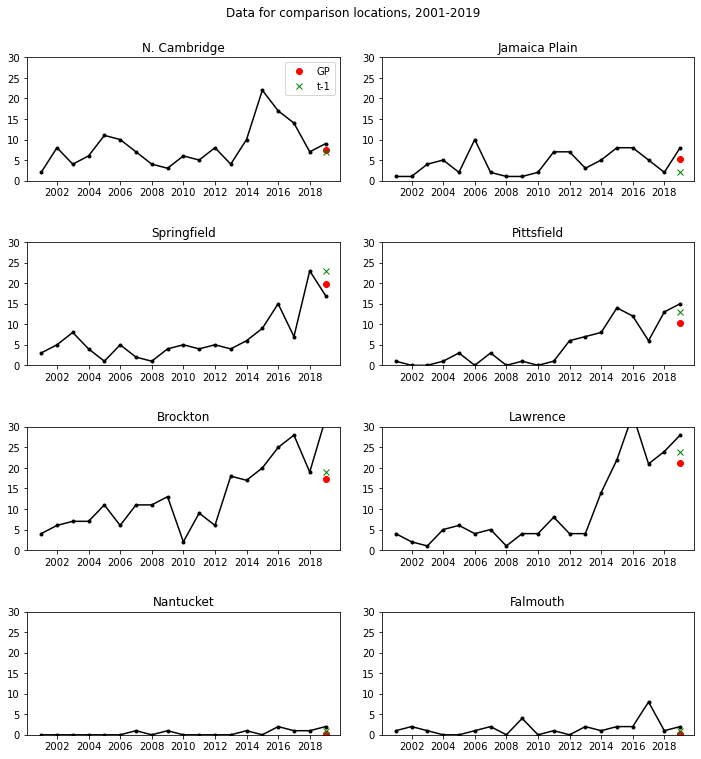

In [105]:
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(10,10))
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)
for c, comparison in comparisons.iterrows():
    row = int(np.floor(c/2))
    col = c%2
    ax = axs[row, col]
    

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylim([0,30])
    ax.set_title(comparison['name'])
        
    avg =  train_y_through_2019[train_y_through_2019['grid_squar']==comparison['center']].groupby('year').mean()['deaths']
    ax.plot(np.arange(2001, 2020), avg, 'k.-')
    
    ax.plot(2019, pred_2019_df.loc[comparison['center']],'ro', label='GP')
    ax.plot(2019,train_y_through_2019[(train_y_through_2019['grid_squar']==comparison['center'])&(train_y_through_2019['year']==2018)]['deaths'],'gx', label='t-1')
    if row==col==0:
        ax.legend()
fig.suptitle("Data for comparison locations, 2001-2019",y=1.05)

In [96]:
pred_2019_df

grid_squar
0      0.000336
1      0.000456
2      0.000477
3      0.000445
4      0.000415
         ...   
957    0.132581
958    0.021528
959    0.090112
960    0.000920
961    0.000781
Length: 962, dtype: float64

In [100]:
train_y_through_2019[(train_y_through_2019['grid_squar']==comparison['center'])&(train_y_through_2019['year']==2018)]['deaths']

,grid_squar,year,deaths
17202,848,2018,1.0


In [52]:
import scipy

In [53]:
scipy.__version__

'1.5.4'

In [25]:
m.savemodel?

In [28]:
m.savemodel('/cluster/home/kheuto01/testsavemodel.mod')

In [31]:
dir(m)

['ProbitExpectations',
 'X',
 'Xtrain',
 'Y',
 'Ytrain',
 'Zf',
 'Zg',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_begin_tf_mode',
 '_end_tf_mode',
 '_html_table_rows',
 '_kill_autoflow',
 '_name',
 '_needs_recompile',
 '_optimize_np',
 '_optimize_tf',
 '_parent',
 '_repr_html_',
 '_session',
 '_tf_mode',
 'build_likelihood',
 'build_predict',
 'build_prior',
 'build_prior_KL',
 'compile',
 'compute_log_likelihood',
 'compute_log_prior',
 'compute_prior_KL',
 'data_holders',
 'fixed',
 'get_feed_dict_keys',
 'get_free_state',
 'get_param_index',
 'get_parameter_dict',
 'get_samples_df',
 'highest_parent',
 'kernf',
 'kerng',
 'li

In [30]:
OnOffSVGP.update_feed_dict?

In [32]:
m.set_parameter_dict?

In [19]:
with open('/cluster/tufts/hugheslab/kheuto01/opioid/logs/qtr/ind100_iter3000/model.pkl','rb') as f:
    m = pickle.load(f)

AttributeError: Can't get attribute 'Add' on <module 'gpflow.kernels' from '/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/modern_zigp/lib/python3.9/site-packages/gpflow/kernels/__init__.py'>

In [18]:
import pickle

In [22]:
with open('/cluster/tufts/hugheslab/kheuto01/opioid/logs/biannual/ind100/model.pkl','rb') as f:
    m = pickle.load(f)

In [30]:
def fixed_top_X(true_qtr_val,pred_qtr_val, X=10, denom_all=False):
    
    top_X_predicted = pred_qtr_val.sort_values(ascending=False)[:X]
    top_X_true = true_qtr_val.sort_values(ascending=False)[:X]


    undisputed_top_predicted = top_X_predicted[top_X_predicted>top_X_predicted.min()]
    num_tied_spots = X - len(undisputed_top_predicted)
    undisputed_top_true = top_X_true[top_X_true > top_X_true.min()]
    num_true_ties = X - len(undisputed_top_true)


    tied_top_predicted = pred_qtr_val[pred_qtr_val==top_X_predicted.min()]
    tied_top_true = true_qtr_val[true_qtr_val==top_X_true.min()]

    error_in_top_true_ties = np.abs(tied_top_true-pred_qtr_val[tied_top_true.index]).sort_values(ascending=True)
    error_in_top_pred_ties = np.abs(true_qtr_val[tied_top_predicted.index]-tied_top_predicted).sort_values(ascending=True)
    top_true_tied_geoids = error_in_top_true_ties[:num_true_ties].index
    top_pred_tied_geoids = error_in_top_pred_ties[:num_tied_spots].index

    best_possible_top_true_geoids = pd.Index.union(undisputed_top_true.index, top_true_tied_geoids)
    best_possible_top_pred_geoids = pd.Index.union(undisputed_top_predicted.index, top_pred_tied_geoids)

    # True values of GEOIDS with highest actual deaths. If ties, finds tied locations that match preds best
    best_possible_true = true_qtr_val[best_possible_top_true_geoids]
    best_possible_pred = true_qtr_val[best_possible_top_pred_geoids]

    assert(len(best_possible_true)==X)
    assert(len(best_possible_pred)==X)

    best_possible_absolute = np.abs(best_possible_true.sum() - best_possible_pred.sum())
    best_possible_ratio = np.abs(best_possible_pred).sum()/np.abs(best_possible_true).sum()


    bootstrapped_tied_indices = np.random.choice(tied_top_predicted.index, (1000, num_tied_spots))
    bootstrapped_all_indices =  [pd.Index.union(undisputed_top_predicted.index,
                                                bootstrap_index) for bootstrap_index in bootstrapped_tied_indices]

    bootstrapped_absolute = np.mean([np.abs(top_X_true.sum() - true_qtr_val[indices].sum()) 
                                     for indices in bootstrapped_all_indices])
    bootstrapped_ratio = np.mean([np.abs(true_qtr_val[indices]).sum()/np.abs(top_X_true).sum()
                                  for indices in bootstrapped_all_indices])
    if denom_all:
        bootstrapped_ratio = np.mean([np.abs(true_qtr_val[indices]).sum()/np.abs(true_qtr_val).sum()
                                  for indices in bootstrapped_all_indices])
    
    return best_possible_absolute, best_possible_ratio, bootstrapped_absolute, bootstrapped_ratio

In [33]:
pred_2019_df

grid_squar
25001010100   NaN
25001010206   NaN
25001010208   NaN
25001010304   NaN
25001010306   NaN
               ..
25027761100   NaN
25027761200   NaN
25027761300   NaN
25027761401   NaN
25027761402   NaN
Name: deaths, Length: 1620, dtype: float64

In [34]:
maes = []
xtop = []
for quarter in range(1,4+1):
    test_x = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019) & (deaths_gdf_with_autoregressive['quarter']==quarter)][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile','neighbor_t-1', 'self_t-1']]
    test_y = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019) & (deaths_gdf_with_autoregressive['quarter']==quarter)][['grid_squar','timestep', 'deaths']]
    #sg_2019 = m.predict_onoffgp(test_x.loc[:, ['lat','lon','timestep','theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']].values)
    #sg_2019 = sg_2019[0]
    sg_2019 = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019-1) & (deaths_gdf_with_autoregressive['quarter']==quarter)][['deaths']].values
    test_y = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019) & (deaths_gdf_with_autoregressive['quarter']==quarter)][['grid_squar','timestep', 'deaths']]
    pred_2019_df = pd.Series(sg_2019.squeeze(), index=x_just_2019q1.grid_squar)

    #maes.append(mean_absolute_error(test_y.deaths, pred_2019_df))
    xtop.append(fixed_top_X(test_y.set_index('grid_squar')['deaths'], pred_2019_df, 324, denom_all=False))
print(np.mean(maes))
print(np.mean([thing[3] for thing in xtop]))

nan
0.3211028592776026


/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/modern_zigp/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/modern_zigp/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [36]:
maes = []
xtop = []
for quarter in [1,3]:
    test_x = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019) & (deaths_gdf_with_autoregressive['quarter']==quarter)][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile','neighbor_t-1', 'self_t-1']]
    test_y = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019) & (deaths_gdf_with_autoregressive['quarter']==quarter)][['grid_squar','timestep', 'deaths']].set_index(['grid_squar','timestep']) + \
    deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019) & (deaths_gdf_with_autoregressive['quarter']==quarter+1)][['grid_squar', 'deaths']].set_index(['grid_squar',])
    
    #test_x = test_x.reset_index()
    test_y = test_y.reset_index()
    
    #sg_2019 = m.predict_onoffgp(test_x.loc[:, ['lat','lon','timestep','theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']].values)
    #sg_2019 = sg_2019[0]
    sg_2019 = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019-1) & (deaths_gdf_with_autoregressive['quarter']==quarter)][['deaths']].values
    pred_2019_df = pd.Series(sg_2019.squeeze(), index=x_just_2019q1.grid_squar)

    maes.append(mean_absolute_error(test_y.deaths, pred_2019_df))
    xtop.append(fixed_top_X(test_y.set_index('grid_squar')['deaths'], pred_2019_df, 324, denom_all=False))
print(np.mean(maes))
print(np.mean([thing[3] for thing in xtop]))

0.6055555555555556
0.4213759699781965


In [40]:
test_y

,grid_squar,timestep,deaths
0,25001010100,78.0,1.0
1,25001010206,78.0,1.0
2,25001010208,78.0,0.0
3,25001010304,78.0,0.0
4,25001010306,78.0,0.0
...,...,...,...
1615,25027761100,78.0,0.0
1616,25027761200,78.0,1.0
1617,25027761300,78.0,0.0
1618,25027761401,78.0,0.0


In [89]:
 m.build_predict(test_x.loc[:, ['lat','lon','timestep','theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']].values)

TypeError: Failed to convert object of type <class 'gpflow.param.Param'> to Tensor. Contents: [1mZf[0m transform:(none) prior:None
[[ 4.08227986e+01 -7.08902698e+01  5.62334584e+01 ...  9.36997797e-01
   4.43697428e-01 -1.49229399e-01]
 [ 4.09596624e+01 -7.19512720e+01  5.81139416e+01 ... -1.47802539e-01
  -3.90566566e-01  1.24074205e-01]
 [ 4.21730109e+01 -7.16430800e+01  5.90026438e+01 ...  7.11397415e-01
   4.71247504e-01  4.19486636e-01]
 ...
 [ 4.26319012e+01 -7.08945840e+01  5.02059646e+01 ...  1.20500757e+00
   5.77575826e-01  4.27321400e-01]
 [ 4.12154233e+01 -7.19608157e+01  1.77871251e+01 ...  1.07416481e+00
   1.45470173e-01 -2.81690370e-01]
 [ 4.04555213e+01 -7.10156803e+01  5.40190133e+01 ...  2.85425099e-01
  -5.43120338e-03 -9.55941440e-02]]. Consider casting elements to a supported type.

In [47]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import contextily as ctx 
import geopandas as gpd 
import os 
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [138]:
plt.xlim([-71.2, -70.9])
plt.ylim([42, 42.6])

42.886778

In [145]:
residual_gdf.plot?

In [153]:
minx

-73.50821

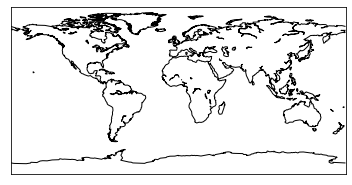

In [212]:
from mpl_toolkits.basemap import Basemap
m=Basemap()
 
# Show the coast lines
m.drawcoastlines()

In [231]:
deaths_and_preds

,grid_squar,timestep,deaths,pred_deaths,residuals
76,25001010100,76.0,0.0,0.198882,-0.198882
77,25001010100,77.0,0.0,0.198882,-0.198882
78,25001010100,78.0,1.0,0.198882,0.801118
79,25001010100,79.0,0.0,0.198882,-0.198882
164,25001010206,76.0,0.0,0.177260,-0.177260
...,...,...,...,...,...
142463,25027761401,79.0,0.0,0.161939,-0.161939
142548,25027761402,76.0,0.0,0.166395,-0.166395
142549,25027761402,77.0,0.0,0.166395,-0.166395
142550,25027761402,78.0,0.0,0.166395,-0.166395


In [50]:
dir(cax)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autoscaleXon',
 '_autoscaleYon',
 '_autotitlepos',
 '_axes',
 '_axes_locator',
 '_axisbelow',
 '_box_aspect',
 '_clipon',
 '_clippath',
 '_contains',
 '_convert_dx',
 '_current_image',
 '_default_contains',
 '_facecolor',
 '_fill_between_x_or_y',
 '_frameon',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spines',
 '_get_axis_list',
 '_get_axis_map',
 '_get_clipping_extent_bbox',
 '_get_lines',
 '_get_patches_for_fill',
 '_get_view',
 '_gid',
 '_gridOn',
 '_in_layout',
 '_init_axis',
